[View in Colaboratory](https://colab.research.google.com/github/telecombcn-dl/2018-dlai/blob/master/dlai2018_d5l_transfer.ipynb)

In [0]:
import keras
keras.__version__
import numpy as np

Using TensorFlow backend.


# Transfer Learning

In this session we will work with convolutional neural networks, when dealing with small datasets, which is a very usual situation, as data can be difficult to obtain in certain scenearios, specially labellel data.


## Downloading the database from Kaggle

During this second lab session, we will work with a small database of images with dogs and cats. The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. It is possible to download the database from the Kaggle website.


As we are working with colaboratory google notebooks, we are working with remote machines, and we need to place the database there. As this database in in Kaggle, we need to use its API to place the database in our remote machine. The first step we will do is to install kaggle command lines to proceed to download the dataset.

In [0]:
!pip install kaggle

    100% |████████████████████████████████| 51kB 8.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /content/.cache/pip/wheels/f1/34/79/fe71f4c2bf112baedf4e5c62e07cdecc018e793c735873afe6
Successfully built kaggle


To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/username/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. The next step is to upload this API Token to the remote machine. Run the following code snippet, and then you can browse which files you want to upload to the remote machine. Choose the API Token from Kaggle, and this is how we will be able to use the Kaggle API in the remote machine.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes



For your security, ensure that other users that are using your remote machine do not have read access to your credentials. You can do this by running the following the two next steps. First, we create a .kaggle directory:


In [0]:
!mkdir .kaggle

And then we run the following command to move to authentication token there:

In [0]:
!mv kaggle.json .kaggle/kaggle.json
!chmod 600 .kaggle/kaggle.json

Finally the following command line will download to your remote machine the Kaggle database that we will need for this lab session. It will take a few seconds.

In [0]:
!kaggle competitions download -c dogs-vs-cats

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 34.9MB/s]
 96%|███████████████████████████████████████▏ | 259M/271M [00:02<00:00, 159MB/s]
100%|█████████████████████████████████████████| 271M/271M [00:02<00:00, 128MB/s]
 97%|███████████████████████████████████████▊ | 527M/543M [00:03<00:00, 139MB/s]
100%|█████████████████████████████████████████| 543M/543M [00:03<00:00, 150MB/s]


Now you will need to unzip the database that you have just downloaded, with the following line:

In [0]:
!unzip -qq /content/.kaggle/competitions/dogs-vs-cats/train.zip -d /datalab/ 

Now you already have the raw images at your remote machine. 

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in 
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We 
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be 
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce 
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve 
our network to reach an accuracy of 82%.

In the last section of today's session, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction 
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to 
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a 
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer 
vision with small datasets.

### The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual 
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because convnets learn local, translation-invariant features, they are very 
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Preparing the data

Some sample images of the cats vs. dogs dataset look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [0]:
import os, shutil

In [0]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/datalab/train/'

# The directory where we will
# store our smaller dataset
base_dir = '/content/processed_datalab'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [0]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [0]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [0]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [0]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [0]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [0]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous lab session, so you should be familiar with them. We will reuse the same  general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one  more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the  feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a  somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is  decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss.

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

Data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to  quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we  will use here.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
 30/100 [========>.....................] - ETA: 1:16 - loss: 0.6951 - acc: 0.5100

KeyboardInterrupt: ignored

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

It is good practice to always save your models after training. In our case we are going to save also the history, so that we can observe the curve later without needing to train the model again. 

In [0]:
model.save('cats_and_dogs_small_1_class.h5')
np.save('history_cats_and_dogs_small_1_class', history.history)


In case you want to download to your computer your  trained model, to use it later, and also the history, you can run the following commands:



In [0]:
from google.colab import files
files.download('cats_and_dogs_small_1_class.h5')
files.download('history_cats_and_dogs_small_1_class.npy')

In our case, as the training takes some time and we want to go on with the lab, we will download to the remote machine some pretrained weights for this model, instead of waiting until the end of the session, as well as the history record. The code for this is the following: 





In [0]:
!wget "https://drive.google.com/uc?export=download&id=1PKojE8PA_NLSUdafL5HPP0MRnJ0zyVc3" -O cats_and_dogs_small_1.h5
!wget "https://drive.google.com/uc?export=download&id=1PtngoB0S-J1kbZoWOjJQH1_UwlPOcSZs" -O history_cats_and_dogs_small_1.npy

--2018-06-14 08:33:55--  https://drive.google.com/uc?export=download&id=1PKojE8PA_NLSUdafL5HPP0MRnJ0zyVc3
Resolving drive.google.com (drive.google.com)... 74.125.197.102, 74.125.197.100, 74.125.197.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nmfqqkqf89eanc9mheri8gsdm6chiov4/1528963200000/01444967530925424933/*/1PKojE8PA_NLSUdafL5HPP0MRnJ0zyVc3?e=download [following]
--2018-06-14 08:33:57--  https://doc-0g-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nmfqqkqf89eanc9mheri8gsdm6chiov4/1528963200000/01444967530925424933/*/1PKojE8PA_NLSUdafL5HPP0MRnJ0zyVc3?e=download
Resolving doc-0g-78-docs.googleusercontent.com (doc-0g-78-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c03::84
Connecting to doc-0g-78-docs.googleusercontent.com (doc-0g

And now let's update the parameters of your model with these pretrained weights, with the following command:

In [0]:
model.load_weights("cats_and_dogs_small_1.h5")

Run the following commands if you want to visualize the curve of your own trained model ...

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

... or the next code if you want to see how does the curve look after training the model:

In [0]:
history_dict = np.load('history_cats_and_dogs_small_1.npy')

acc = history_dict.item().get('acc')
val_acc = history_dict.item().get('val_acc')
loss = history_dict.item().get('loss')
val_loss = history_dict.item().get('val_loss')

Let's plot the loss and accuracy of the model over the training and validation data during training:

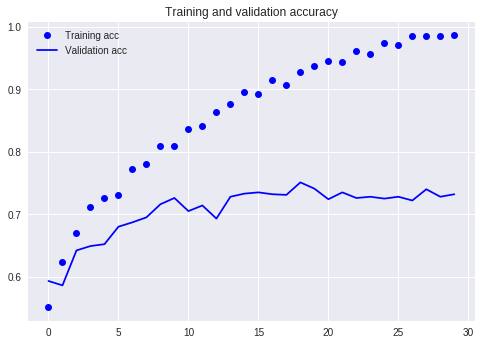

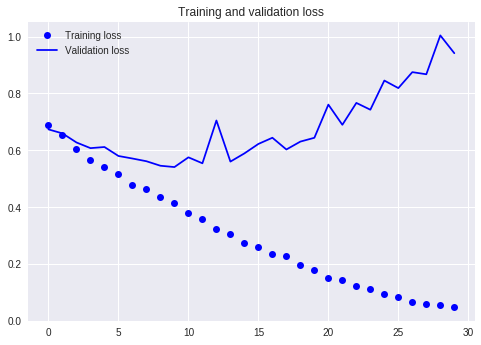

In [0]:
import matplotlib.pyplot as plt

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## 1.  Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

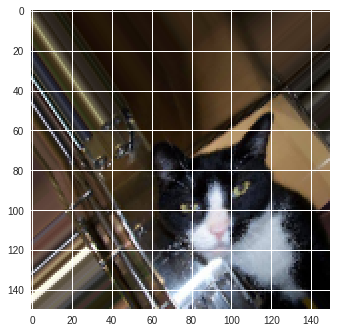

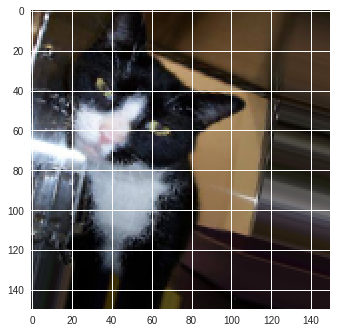

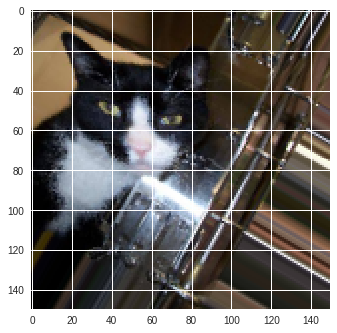

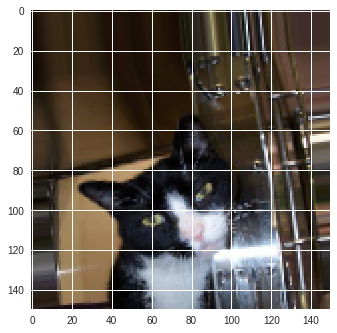

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
 29/100 [=======>......................] - ETA: 2:18 - loss: 0.6927 - acc: 0.5345

KeyboardInterrupt: ignored

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2_class.h5')
np.save('history_cats_and_dogs_small_2_class', history.history)


In [0]:
files.download('cats_and_dogs_small_2_class.h5') 
files.download('history_cats_and_dogs_small_2_class.npy') 

I fyou want to plot the accuracy and losses curves of your own trained model, run the following ...

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

Otherwise load the history record of a pretrained model to check the whole training curve:

In [0]:
!wget "https://drive.google.com/uc?export=download&id=1YXgnLK-hMM-UuvwohCEZsTO-liH9lrv3" -O cats_and_dogs_small_2.h5  
!wget "https://drive.google.com/uc?export=download&id=1zENYYWN3uLHOFZYeGXON00ks-PT2LWQW" -O history_cats_and_dogs_small_2.npy

history_dict = np.load('history_cats_and_dogs_small_2.npy')

acc = history_dict.item().get('acc')
val_acc = history_dict.item().get('val_acc')
loss = history_dict.item().get('loss')
val_loss = history_dict.item().get('val_loss')

--2018-06-14 08:40:47--  https://drive.google.com/uc?export=download&id=1YXgnLK-hMM-UuvwohCEZsTO-liH9lrv3
Resolving drive.google.com (drive.google.com)... 74.125.197.100, 74.125.197.102, 74.125.197.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/62rg54saeh6mfi62ncrn13r30m5l3qbu/1528963200000/01444967530925424933/*/1YXgnLK-hMM-UuvwohCEZsTO-liH9lrv3?e=download [following]
--2018-06-14 08:40:49--  https://doc-0c-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/62rg54saeh6mfi62ncrn13r30m5l3qbu/1528963200000/01444967530925424933/*/1YXgnLK-hMM-UuvwohCEZsTO-liH9lrv3?e=download
Resolving doc-0c-78-docs.googleusercontent.com (doc-0c-78-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0c-78-docs.googleusercontent.com (doc-0c

Plot the curves with the following lines:

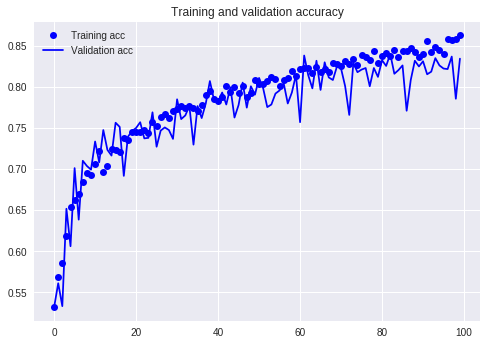

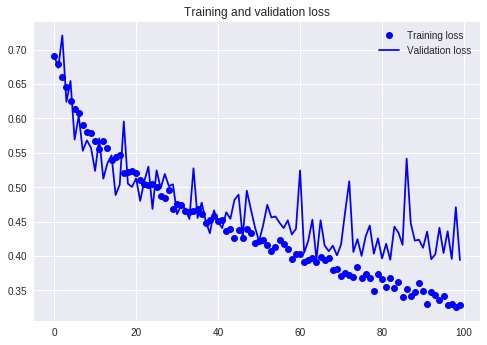

In [0]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.

# 2 Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. 

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will cover both of them. Let's start with feature extraction. Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.


![settings](https://camo.githubusercontent.com/2de162f6f3587a0422389355909594413ae17742/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f7377617070696e675f66635f636c61737369666965722e706e67)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the keras.applications module. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of keras.applications:

    Xception
    InceptionV3
    ResNet50
    VGG16
    VGG19
    MobileNet

Let's instantiate the VGG16 model:


In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 4s 0us/step




We passed three arguments to the constructor:



*   **weights**, to specify which weight checkpoint to initialize the model from
*   **include_top**, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
*   **input_shape**, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.


Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already familiar with.


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________



The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier.

The method we will use consists in running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.


We will start by simply running instances of the previously-introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the predict method of the conv_base model.


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/processed_datalab'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


KeyboardInterrupt: ignored

The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, so first we must flatten them to (samples, 8192):

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

NameError: ignored

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that we just recorded:

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6063 - acc: 0.6660 - val_loss: 0.4541 - val_acc: 0.8270
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4424 - acc: 0.7995 - val_loss: 0.3759 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3549 - acc: 0.8485 - val_loss: 0.3265 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3156 - acc: 0.8685 - val_loss: 0.2983 - val_acc: 0.8940
Epoch 5/30
1860/2000 [==========================>...] - ETA: 0s - loss: 0.2828 - acc: 0.8871

2000/2000 [==============================] - 3s 2ms/step - loss: 0.2851 - acc: 0.8850 - val_loss: 0.2843 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2672 - acc: 0.8910 - val_loss: 0.2716 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2484 - acc: 0.9055 - val_loss: 0.2826 - val_acc: 0.8950
Epoch 8/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2337 - acc: 0.9065 - val_loss: 0.2577 - val_acc: 0.9010
Epoch 9/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2161 - acc: 0.9210 - val_loss: 0.2563 - val_acc: 0.9030
Epoch 10/30
 700/2000 [=========>....................] - ETA: 1s - loss: 0.2243 - acc: 0.9129

2000/2000 [==============================] - 3s 2ms/step - loss: 0.2132 - acc: 0.9190 - val_loss: 0.2462 - val_acc: 0.9030
Epoch 11/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1912 - acc: 0.9315 - val_loss: 0.2457 - val_acc: 0.9060
Epoch 12/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1837 - acc: 0.9365 - val_loss: 0.2487 - val_acc: 0.9020
Epoch 13/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1760 - acc: 0.9340 - val_loss: 0.2404 - val_acc: 0.9040
Epoch 14/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1698 - acc: 0.9380 - val_loss: 0.2390 - val_acc: 0.9040
Epoch 15/30
 580/2000 [=======>......................] - ETA: 2s - loss: 0.1557 - acc: 0.9397

2000/2000 [==============================] - 3s 2ms/step - loss: 0.1645 - acc: 0.9355 - val_loss: 0.2446 - val_acc: 0.9050
Epoch 16/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1610 - acc: 0.9445 - val_loss: 0.2358 - val_acc: 0.9060
Epoch 17/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1459 - acc: 0.9480 - val_loss: 0.2402 - val_acc: 0.9030
Epoch 18/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1444 - acc: 0.9525 - val_loss: 0.2332 - val_acc: 0.9030
Epoch 19/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1354 - acc: 0.9555 - val_loss: 0.2319 - val_acc: 0.9060
Epoch 20/30
 580/2000 [=======>......................] - ETA: 2s - loss: 0.1070 - acc: 0.9621

2000/2000 [==============================] - 3s 2ms/step - loss: 0.1331 - acc: 0.9550 - val_loss: 0.2344 - val_acc: 0.9040
Epoch 21/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1275 - acc: 0.9535 - val_loss: 0.2336 - val_acc: 0.9020
Epoch 22/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1200 - acc: 0.9660 - val_loss: 0.2427 - val_acc: 0.9050
Epoch 23/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1162 - acc: 0.9640 - val_loss: 0.2357 - val_acc: 0.9010
Epoch 24/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1128 - acc: 0.9635 - val_loss: 0.2325 - val_acc: 0.9100
Epoch 25/30
 540/2000 [=======>......................] - ETA: 2s - loss: 0.1128 - acc: 0.9685

2000/2000 [==============================] - 3s 2ms/step - loss: 0.1120 - acc: 0.9650 - val_loss: 0.2336 - val_acc: 0.9010
Epoch 26/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1059 - acc: 0.9665 - val_loss: 0.2339 - val_acc: 0.9030
Epoch 27/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0992 - acc: 0.9745 - val_loss: 0.2359 - val_acc: 0.9030
Epoch 28/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0907 - acc: 0.9725 - val_loss: 0.2398 - val_acc: 0.9020
Epoch 29/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0915 - acc: 0.9700 - val_loss: 0.2484 - val_acc: 0.9010
Epoch 30/30
 540/2000 [=======>......................] - ETA: 2s - loss: 0.0838 - acc: 0.9778

2000/2000 [==============================] - 3s 2ms/step - loss: 0.0904 - acc: 0.9745 - val_loss: 0.2385 - val_acc: 0.9030


Training is very fast, since we only have to deal with two Dense layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:


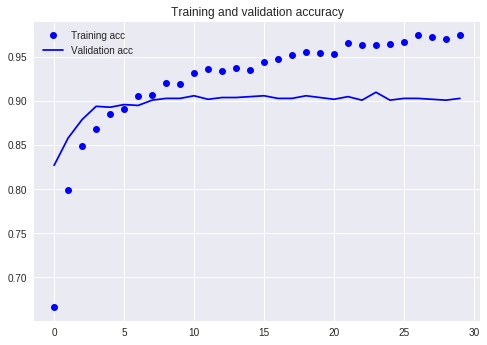

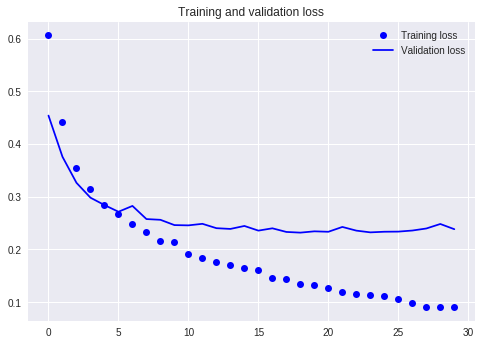

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.



# 3. Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![finetuning](https://camo.githubusercontent.com/28a6cb7048317aba34f39cb02f15520708189008/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f76676731365f66696e655f74756e696e672e706e67)

First,  let's extend the model we have (conv_base) by adding the Dense layers on top, and run the whole thing end-to-end oin the input data. This allows us, first, to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))




This is what our model looks like now:


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In this case, we can do data augmentation, with the same configuration we used in our previous example:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:


1.   Add your custom network on top of an already trained base network.
2.   Freeze the base network.
3.   Train the part you added.
4.   Unfreeze some layers in the base network.
5.   Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our conv_base, and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

1.   Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
2.   The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:


In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:


In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
  4/100 [>.............................] - ETA: 9:21 - loss: 0.7199 - acc: 0.4625

KeyboardInterrupt: ignored

In [0]:
model.save('cats_and_dogs_small_3_class.h5')
np.save('history_cats_and_dogs_small_3_class', history.history)

As we did previously, if there is no time to run the whole training, you can download the already trained weights for this configuration, together with the history record, running the following command: 

In [0]:
!wget "https://drive.google.com/uc?export=download&id=1kbNx8AnVPenNX18RVn7hnIIQZUE-AW38" -O cats_and_dogs_small_3.h5
!wget "https://drive.google.com/uc?export=download&id=1_ySA1hn3gEPcHISc5wlwiTwFPeOGH42a" -O history_cats_and_dogs_small_3.npy

history_dict = np.load('history_cats_and_dogs_small_3.npy')
model.load_weights('cats_and_dogs_small_3.h5')

acc = history_dict.item().get('acc')
val_acc = history_dict.item().get('val_acc')
loss = history_dict.item().get('loss')
val_loss = history_dict.item().get('val_loss')

--2018-06-14 08:53:14--  https://drive.google.com/uc?export=download&id=1kbNx8AnVPenNX18RVn7hnIIQZUE-AW38
Resolving drive.google.com (drive.google.com)... 173.194.203.101, 173.194.203.100, 173.194.203.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5lvkicqjig38lt51g6u33qal0pqgvphl/1528963200000/01444967530925424933/*/1kbNx8AnVPenNX18RVn7hnIIQZUE-AW38?e=download [following]
--2018-06-14 08:53:19--  https://doc-0g-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5lvkicqjig38lt51g6u33qal0pqgvphl/1528963200000/01444967530925424933/*/1kbNx8AnVPenNX18RVn7hnIIQZUE-AW38?e=download
Resolving doc-0g-78-docs.googleusercontent.com (doc-0g-78-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0g-78-docs.googleusercontent.com (do

However, if you want to plot your own training curves, run the following lines:

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

And finally plot the curves: 

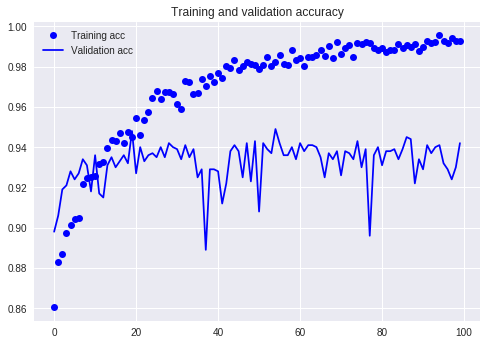

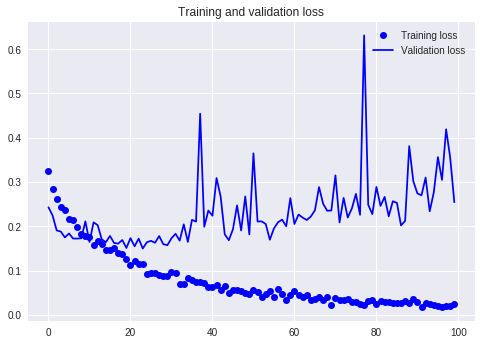

In [0]:
import matplotlib.pyplot as plt


epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

You can observe that the accuracy is higher compared to what we had before doing finetuning.  We can now finally evaluate this model on the test data:

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9299999916553497


Here we get a test accuracy of 93%. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

# Take-aways: using convnets with small datasets

Here's what you should take away from these exercises:


*   Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
*   On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
*    It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
*   As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.